In [70]:
import tensorflow as tf
import numpy as np
from datetime import datetime as dt
import numpy.random as rnd
from sklearn.preprocessing import StandardScaler
from tensorflow.examples.tutorials.mnist import input_data
import sys
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    sample = np.random.randint(0, mnist.test.num_examples - n_test_digits)
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[sample:sample + n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

def show_reconstructed_noisy_digits(X, X_noisy,outputs, model_path = None, n_test_digits = 2):
    sample = np.random.randint(0, mnist.test.num_examples - n_test_digits)
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[sample:sample + n_test_digits]
        X_test_noisy = X_noisy.eval(feed_dict={X: X_test})
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test_noisy[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [5]:
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

No handles with labels found to put in legend.


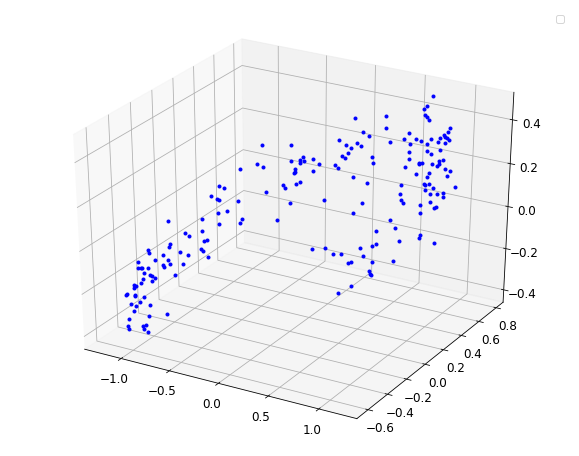

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot(data[:, 0] , data[:, 1],data[:, 2] , "b.")
ax.legend()

plt.show()

In [17]:
reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

hidden = tf.contrib.layers.fully_connected(X, n_hidden, activation_fn = None)
outputs = tf.contrib.layers.fully_connected(hidden, n_outputs, activation_fn = None)

codings = hidden

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

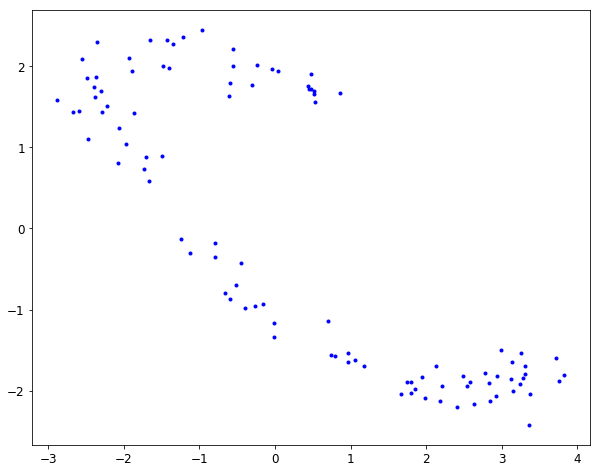

In [18]:
n_iterations = 1000

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict = {X : X_train})
    codings_val = codings.eval(feed_dict = {X : X_test})

fig = plt.figure(figsize=(10,8))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.show()

# Stacked Autoencoder

In [21]:
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [27]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.001

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

with tf.contrib.framework.arg_scope([tf.contrib.layers.fully_connected], activation_fn = tf.nn.elu, 
                                   weights_initializer = tf.contrib.layers.variance_scaling_initializer(),
                                   weights_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)):
    hidden1 = tf.contrib.layers.fully_connected(X, n_hidden1)
    hidden2 = tf.contrib.layers.fully_connected(hidden1, n_hidden2)
    hidden3 = tf.contrib.layers.fully_connected(hidden2, n_hidden3)
    outputs = tf.contrib.layers.fully_connected(hidden3, n_outputs, activation_fn = None)
    
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    n_batches = mnist.train.num_examples // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
    save_path = saver.save(sess, "./CH15/models/stacked_autoencoder_mnist.ckpt")    

INFO:tensorflow:Restoring parameters from ./CH15/models/stacked_autoencoder_mnist.ckpt


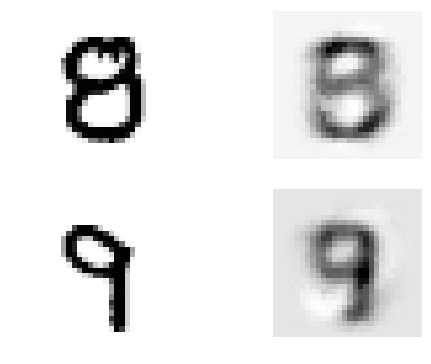

In [31]:
show_reconstructed_digits(X, outputs, "./CH15/models/stacked_autoencoder_mnist.ckpt")

## Tying weights

In [39]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.001

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype = tf.float32, name = "weights1")
weights2 = tf.Variable(weights2_init, dtype = tf.float32, name = "weights2")
weights3 = tf.transpose(weights2, name = "weights3")
weights4 = tf.transpose(weights1, name = "weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name = "biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name = "biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name = "biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name = "biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_losses

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

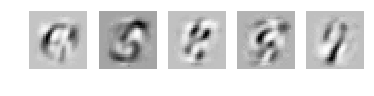

In [40]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    n_batches = mnist.train.num_examples // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
    weights1_val = weights1.eval()
    for i in range(5):
        plt.subplot(1,5,i+1)
        plot_image(weights1_val.T[i])
    save_path = saver.save(sess, "./CH15/models/stacked_autoencoder_with_tied_weights_mnist.ckpt")  

INFO:tensorflow:Restoring parameters from ./CH15/models/stacked_autoencoder_with_tied_weights_mnist.ckpt


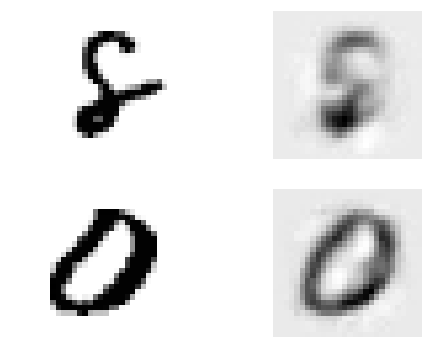

In [38]:
show_reconstructed_digits(X, outputs, "./CH15/models/stacked_autoencoder_with_tied_weights_mnist.ckpt")

## Denoising autoencoder

In [49]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = n_inputs
n_hidden2 = n_inputs
n_hidden3 = n_inputs
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.001

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
X_noisy = X + tf.random_normal(tf.shape(X), stddev=0.05)

with tf.contrib.framework.arg_scope([tf.contrib.layers.fully_connected], activation_fn = tf.nn.elu, 
                                   weights_initializer = tf.contrib.layers.variance_scaling_initializer(),
                                   weights_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)):
    hidden1 = tf.contrib.layers.fully_connected(X_noisy, n_hidden1)
    hidden2 = tf.contrib.layers.fully_connected(hidden1, n_hidden2)
    hidden3 = tf.contrib.layers.fully_connected(hidden2, n_hidden3)
    outputs = tf.contrib.layers.fully_connected(hidden3, n_outputs, activation_fn = None)
    
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [50]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    n_batches = mnist.train.num_examples // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
    save_path = saver.save(sess, "./CH15/models/stacked_denoising_autoencoder_mnist.ckpt")    

INFO:tensorflow:Restoring parameters from ./CH15/models/stacked_denoising_autoencoder_mnist.ckpt


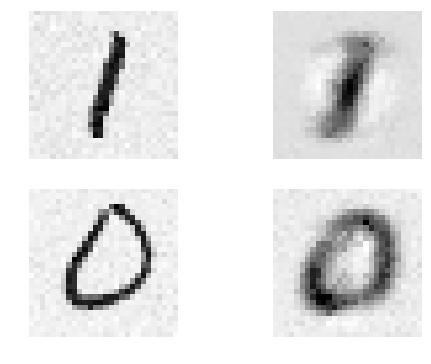

In [54]:
show_reconstructed_noisy_digits(X, X_noisy, outputs, "./CH15/models/stacked_denoising_autoencoder_mnist.ckpt")

## Sparse autoencoder

In [62]:
def kl_divergence(p, q):
    return p*tf.log(p/q) + (1-p)*tf.log((1-p)/(1-q))

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000
n_outputs = n_inputs
sparsity_target = 0.1
sparsity_weight = 0.2

learning_rate = 0.01

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

hidden1 = tf.contrib.layers.fully_connected(X, n_hidden1, activation_fn = tf.nn.sigmoid)
outputs = tf.contrib.layers.fully_connected(hidden1, n_outputs, weights_regularizer = regularizer, activation_fn = None)
    
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
hidden1_mean = tf.reduce_mean(hidden1, axis = 0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))

loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [63]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    n_batches = mnist.train.num_examples // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
    save_path = saver.save(sess, "./CH15/models/sparse_autoencoder_mnist.ckpt")    

INFO:tensorflow:Restoring parameters from ./CH15/models/sparse_autoencoder_mnist.ckpt


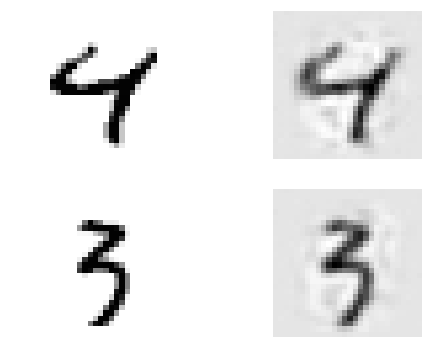

In [65]:
show_reconstructed_digits(X, outputs, "./CH15/models/sparse_autoencoder_mnist.ckpt")

## Variational autoencoder

In [68]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_inputs])

with tf.contrib.framework.arg_scope([tf.contrib.layers.fully_connected], activation_fn = tf.nn.elu, 
                                   weights_initializer = tf.contrib.layers.variance_scaling_initializer()):
    hidden1 = tf.contrib.layers.fully_connected(X, n_hidden1)
    hidden2 = tf.contrib.layers.fully_connected(hidden1, n_hidden2)
    hidden3_mean = tf.contrib.layers.fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = tf.contrib.layers.fully_connected(hidden2, n_hidden3, activation_fn=None)
    noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
    hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
    hidden4 = tf.contrib.layers.fully_connected(hidden3, n_hidden4)
    hidden5 = tf.contrib.layers.fully_connected(hidden4, n_hidden5)
    logits = tf.contrib.layers.fully_connected(hidden5, n_outputs, activation_fn=None)
    outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [71]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18122.33 	Reconstruction loss: 14431.301 	Latent loss: 3691.0288
1 Train total loss: 16982.754 	Reconstruction loss: 13297.87 	Latent loss: 3684.8828
29% Train total loss: 16317.717 	Reconstruction loss: 12486.18 	Latent loss: 3831.5374
3 Train total loss: 16845.043 	Reconstruction loss: 13035.955 	Latent loss: 3809.0881
4 Train total loss: 15619.805 	Reconstruction loss: 11899.955 	Latent loss: 3719.8496
5 Train total loss: 16640.37 	Reconstruction loss: 12841.021 	Latent loss: 3799.3477
6 Train total loss: 15319.777 	Reconstruction loss: 11581.898 	Latent loss: 3737.8794
7 Train total loss: 16164.294 	Reconstruction loss: 12358.082 	Latent loss: 3806.212
8 Train total loss: 15377.061 	Reconstruction loss: 11599.459 	Latent loss: 3777.6016
9 Train total loss: 15346.583 	Reconstruction loss: 11636.455 	Latent loss: 3710.128
10 Train total loss: 15646.808 	Reconstruction loss: 11895.582 	Latent loss: 3751.2258
11 Train total loss: 15898.898 	Reconstruction loss: 1209